# Interpolated SST Gradient Exploration

In this notebook, I investigate the results of the SST gradient through its values interpolated to the drifter positions. 

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('seaducks'), '..')))
from seaducks.analysis import summary_plots
from seaducks import assign_each_position_a_bin


# configure plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

plt.style.use('ggplot')

In [2]:
from shapely.geometry import Polygon
def cuts2poly(tuple_tuple) -> Polygon:
    """

    Args:
        tuple_tuple: a tuple of pd cuts, designed for .groupby([lon_cut, lat_cut]) operations
    Returns:
         a Shapely Polygon containing the square resulting from the cuts.
    """
    lon, lat = tuple_tuple
    lon1, lon2 = lon.left, lon.right
    lat1, lat2 = lat.left, lat.right
    return Polygon(np.array([(lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2)]))

In [3]:
# load the drifter dataset
drifter_dataset = pd.read_hdf('../data/filtered_nao_drifters_with_sst_gradient.h5')

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from mpl_toolkits.axes_grid1 import make_axes_locatable

extent = [-85.01,#summaries['lon'].min(),
          drifter_dataset['lon'].max(),
          -0.01,
          drifter_dataset['lat'].max()
         ]
def add_gridlines(ax, xlocs = [-85, -70, -55, -40],
                      ylocs = list(range(0,66,15))):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray',
                      alpha=0.5, linestyle='--', 
                      
                     )
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines=False
    gl.xlocator = mticker.FixedLocator(xlocs)
    gl.ylocator = mticker.FixedLocator(ylocs)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
def plot_column(daf, column, ax, cmap='seismic', vmin_manual=None, vmax_manual=None):
    vmin, vmax =daf[column].min(), daf[column].max()
    changed_vmin, changed_vmax = False, False
    if vmin_manual is not None:
        changed_vmin = vmin!=vmin_manual
        vmin = vmin_manual
    if vmax_manual is not None:
        changed_vmax = vmax!=vmax_manual
        vmax = vmax_manual
        #norm = mpl.colors.LogNorm(vmin=daf[column].min(), vmax=daf[column].max())
    extend="neither"
    if changed_vmin:
        if changed_vmax:
            extend="both"
        else:
            extend="min"
    else:
        if changed_vmax:
            extend="max"
        
    
    if cmap == 'seismic':
        norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0,vmax=vmax)
    else:
        norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0,vmax=vmax)
    cmap = plt.get_cmap(cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
    f = ax.get_figure()
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical',
                                   extend=extend)
    f.add_axes(cax)
    crs = ccrs.PlateCarree()
    for color, rows in daf.groupby(column):
        color_mapped = sm.cmap(norm(color))
        ax.add_geometries(
            rows["geometry"], crs=crs, facecolor=color_mapped, edgecolor=color_mapped
        )
    return cax

def add_letters(axs):
    for n, ax in enumerate(axs.flatten()):
        ax.text(-0.26, 0.5, '', transform=ax.transAxes, 
            size=13, weight='bold')


# Investigating Correlation

Considering the correlation between SST gradient and drifter velocities

In [18]:
def corr_df(drifter_dataset,lat_grid,lon_grid,bin_size,corr_pairs):
    
    df = assign_each_position_a_bin(drifter_dataset,lat_grid, lon_grid, bin_size=bin_size)
    vars = df.columns

    #initialise
    idx = np.array(pd.DataFrame(df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, 
                                  observed=False)[vars].apply(lambda row: row[corr_pairs[0]].corr()).iloc[0::2,-1]).index)
    idx0 = [ii[0] for ii in idx]
    idx1 = [ii[1] for ii in idx]

    plot_frame = pd.DataFrame(index=[idx0,idx1])

    for pair in corr_pairs:
        name = pair[0]+'_'+ pair[1]
        plot_frame.loc[:,name] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, 
                                  observed=False)[vars].apply(lambda row: row[pair].corr().iloc[0, 1]).values
        
    plot_frame.dropna(inplace=True)
    gpd = list(map(cuts2poly,plot_frame.index))
    plot_frame['geometry']=gpd

    return plot_frame




Correlation between drifter velocity and SST gradient

In [19]:
bin_size = 0.5
lat_grid = np.arange(-90,90 + bin_size,bin_size)
lon_grid = np.arange(-180,180 + bin_size,bin_size)
#corr_pairs = [['u','sst_x_derivative']]
corr_pairs = [['u','sst_x_derivative'],['v','sst_x_derivative'],['u','sst_y_derivative'],['v','sst_y_derivative']]
metric_names = [pair[0]+'_'+pair[1] for pair in corr_pairs]
print(metric_names)

df_drifter_velocity_sst_gradient = corr_df(drifter_dataset,lat_grid,lon_grid,bin_size,corr_pairs)
cbar_names = ["", "", "", "", "", "", "", ""]
titles = [r'$\displaystyle \mathrm{corr} \left (u,\partial T/\partial x \right)$',
          r'$\displaystyle \mathrm{corr} \left (v,\partial T/\partial x \right)$',
          r'$\displaystyle \mathrm{corr} \left (u,\partial T/\partial y \right)$',
          r'$\displaystyle \mathrm{corr} \left (v,\partial T/\partial y \right)$'
         ]

['u_sst_x_derivative', 'v_sst_x_derivative', 'u_sst_y_derivative', 'v_sst_y_derivative']


fig successful
u_sst_x_derivative plot successful
v_sst_x_derivative plot successful
u_sst_y_derivative plot successful
v_sst_y_derivative plot successful
letters added


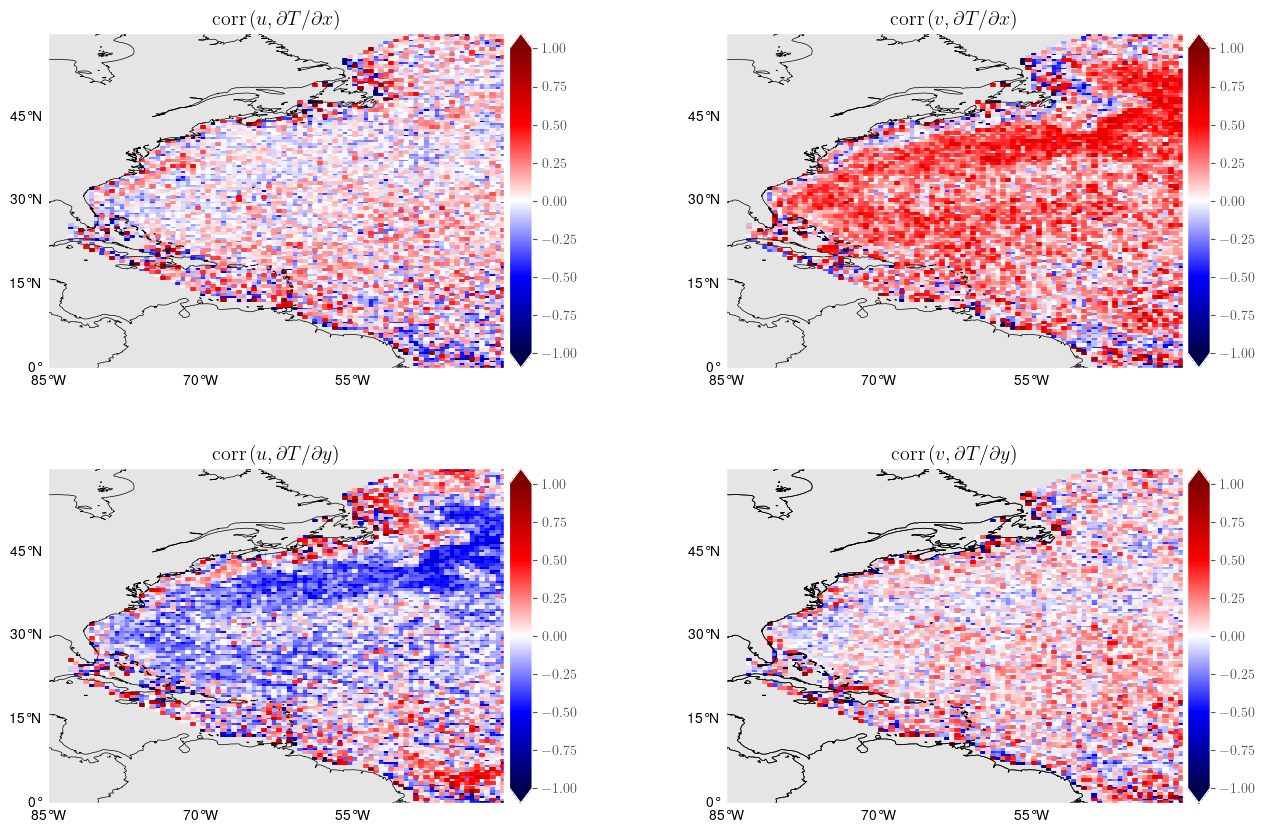

In [20]:
# define df to plot
df = df_drifter_velocity_sst_gradient

fig, axs = plt.subplots(2,2,figsize=(15,10), subplot_kw= {"projection":ccrs.PlateCarree()})
print('fig successful')
for i, metric in enumerate(metric_names):
    col = int(i%2)
    row = int((i-col)/2)
    current_ax = axs[row,col]
    cax = plot_column(df,
                      metric,
                      ax=current_ax,
                      vmax_manual=1,
                      vmin_manual=-1,
                      cmap='seismic')
    print(f'{metric} plot successful')
    current_ax.set_title(titles[i])
    current_ax.set_extent(extent,ccrs.PlateCarree())
    current_ax.coastlines()
    current_ax.set_aspect('auto')
    add_gridlines(current_ax)
    cax.set_ylabel(cbar_names[i], labelpad=0.1)
    
add_letters(axs)
print('letters added')
plt.subplots_adjust(wspace=0.4, hspace=0.3)
axs[1,1].coastlines()
axs[1,1].set_aspect('auto')

plt.show()

In [7]:
df_drifter_velocity_sst_gradient

u_sst_x_derivative  v_sst_x_derivative  \
(-48.0, -47.5] (47.0, 47.5]            0.011983           -0.252117   
               (46.5, 47.0]           -0.112194           -0.113923   
               (46.0, 46.5]           -0.547905           -0.496149   
               (45.5, 46.0]           -0.018931           -0.036808   
(-48.5, -48.0] (45.0, 45.5]           -0.081233           -0.081275   
...                                         ...                 ...   
(-40.5, -40.0] (18.5, 19.0]            0.424192           -0.327878   
(-79.0, -78.5] (33.0, 33.5]            0.640652            0.558450   
(-77.5, -77.0] (34.5, 35.0]            0.346045            0.341808   
(-58.5, -58.0] (8.0, 8.5]             -0.232748           -0.035749   
(-59.0, -58.5] (8.0, 8.5]             -1.000000            1.000000   

                             u_sst_y_derivative  v_sst_y_derivative  \
(-48.0, -47.5] (47.0, 47.5]           -0.013626           -0.096404   
               (46.5, 47.0]           -0.044241            0.001345   
               (46.0, 46.5]            0.525757            0.415067   
               (45.5, 46.0]            0.202405            0.108325   
(-48.5, -48.0] (45.0, 45.5]            0.055812            0.131637   
...                                         ...                 ...   
(-40.5, -40.0] (18.5, 19.0]            0.197314            0.232473   
(-79.0, -78.5] (33.0, 33.5]           -0.360476           -0.375966   
(-77.5, -77.0] (34.5, 35.0]            0.712321            0.449836   
(-58.5, -58.0] (8.0, 8.5]              0.284090           -0.531927   
(-59.0, -58.5] (8.0, 8.5]             -1.000000            1.000000   

                                                                      geometry  
(-48.0, -47.5] (47.0, 47.5]  POLYGON ((-48 47, -47.5 47, -47.5 47.5, -48 47...  
               (46.5, 47.0]  POLYGON ((-48 46.5, -47.5 46.5, -47.5 47, -48 ...  
               (46.0, 46.5]  POLYGON ((-48 46, -47.5 46, -47.5 46.5, -48 46...  
               (45.5, 46.0]  POLYGON ((-48 45.5, -47.5 45.5, -47.5 46, -48 ...  
(-48.5, -48.0] (45.0, 45.5]  POLYGON ((-48.5 45, -48 45, -48 45.5, -48.5 45...  
...                                                                        ...  
(-40.5, -40.0] (18.5, 19.0]  POLYGON ((-40.5 18.5, -40 18.5, -40 19, -40.5 ...  
(-79.0, -78.5] (33.0, 33.5]  POLYGON ((-79 33, -78.5 33, -78.5 33.5, -79 33...  
(-77.5, -77.0] (34.5, 35.0]  POLYGON ((-77.5 34.5, -77 34.5, -77 35, -77.5 ...  
(-58.5, -58.0] (8.0, 8.5]    POLYGON ((-58.5 8, -58 8, -58 8.5, -58.5 8.5, ...  
(-59.0, -58.5] (8.0, 8.5]    POLYGON ((-59 8, -58.5 8, -58.5 8.5, -59 8.5, ...  

[6301 rows x 5 columns]

In [13]:
lons = np.array([(idx[0].left +idx[0].right)/2 for idx in df_drifter_velocity_sst_gradient.index])
lats = np.array([(idx[1].left +idx[1].right)/2 for idx in df_drifter_velocity_sst_gradient.index])

df_drifter_velocity_sst_gradient['lon'] = lons
df_drifter_velocity_sst_gradient['lat'] = lats

In [22]:
gulf_stream = df_drifter_velocity_sst_gradient.query('-45 < lon < -40 and 43 <lat <48')

In [41]:
print(np.mean(np.abs(df_drifter_velocity_sst_gradient.query('-75 < lon < -55 and 35 <lat <40')['v_sst_x_derivative'])))

0.281175047719874


Correlation between geostrophic velocity and SST gradient

In [51]:
bin_size = 0.5
lat_grid = np.arange(-90,90 + bin_size,bin_size)
lon_grid = np.arange(-180,180 + bin_size,bin_size)
corr_pairs = [['u_av','sst_x_derivative'],['v_av','sst_x_derivative'],['u_av','sst_y_derivative'],['v_av','sst_y_derivative']]
metric_names = [pair[0]+'_'+pair[1] for pair in corr_pairs]

df_geostrophic_velocity_sst_gradient = corr_df(drifter_dataset,lat_grid,lon_grid,bin_size,corr_pairs)
cbar_names = ["", "", "", "", "", "", "", ""]
titles = [r'$\displaystyle \mathrm{corr} \left (u_{\mathrm{geo}},\partial T/\partial x \right)$',
          r'$\displaystyle \mathrm{corr} \left (v_{\mathrm{geo}},\partial T/\partial x \right)$',
          r'$\displaystyle \mathrm{corr} \left (u_{\mathrm{geo}},\partial T/\partial y \right)$',
          r'$\displaystyle \mathrm{corr} \left (v_{\mathrm{geo}},\partial T/\partial y \right)$'
         ]

fig successful
u_av_sst_x_derivative plot successful
v_av_sst_x_derivative plot successful
u_av_sst_y_derivative plot successful
v_av_sst_y_derivative plot successful
letters added


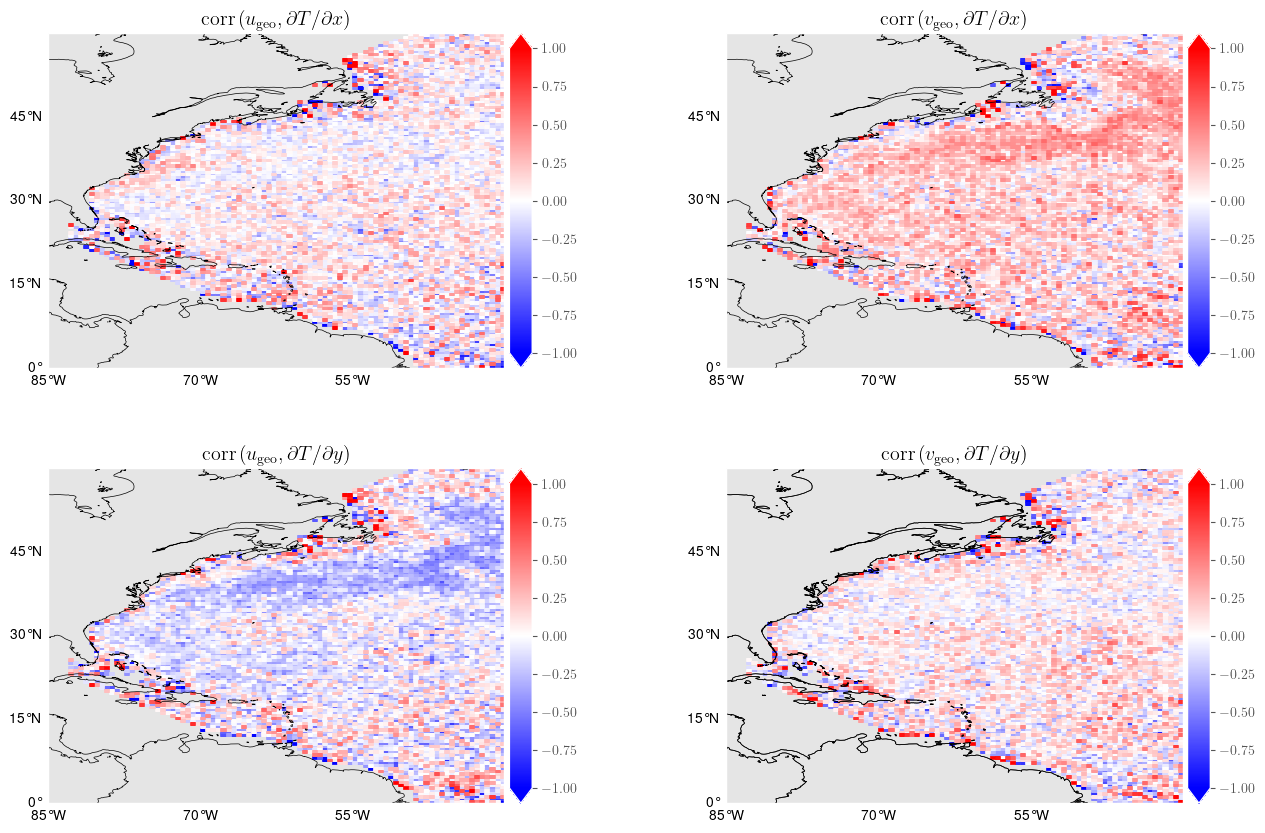

In [55]:
# define df to plot
df = df_geostrophic_velocity_sst_gradient

fig, axs = plt.subplots(2,2,figsize=(15,10), subplot_kw= {"projection":ccrs.PlateCarree()})
print('fig successful')
for i, metric in enumerate(metric_names):
    col = int(i%2)
    row = int((i-col)/2)
    current_ax = axs[row,col]
    cax = plot_column(df,
                      metric,
                      ax=current_ax,
                      vmax_manual=1,
                      vmin_manual=-1,
                      cmap='seismic')
    print(f'{metric} plot successful')
    current_ax.set_title(titles[i])
    current_ax.set_extent(extent,ccrs.PlateCarree())
    current_ax.coastlines()
    current_ax.set_aspect('auto')
    add_gridlines(current_ax)
    cax.set_ylabel(cbar_names[i], labelpad=0.1)
    
add_letters(axs)
print('letters added')
plt.subplots_adjust(wspace=0.4, hspace=0.3)
axs[1,1].coastlines()
axs[1,1].set_aspect('auto')

plt.show()

In [4]:
bin_size = 0.2
lat_grid = np.arange(-90,90 + bin_size,bin_size)
lon_grid = np.arange(-180,180 + bin_size,bin_size)

df_sst_gradient = assign_each_position_a_bin(drifter_dataset,lat_grid, lon_grid, bin_size=bin_size)
vars = df_sst_gradient.columns

In [5]:
df_av_x = df_sst_gradient.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[['lat','lon','sst_x_derivative','sst_y_derivative']].apply(lambda x :np.mean(x['sst_x_derivative']))
df_av_y = df_sst_gradient.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[['lat','lon','sst_x_derivative','sst_y_derivative']].apply(lambda x :np.mean(x['sst_y_derivative']))

In [6]:
idx0 = [idx[0] for idx in np.array(df_av_x.index)]
idx1 = [idx[1] for idx in np.array(df_av_y.index)]

In [7]:
plot_frame_sst = pd.DataFrame(index=[idx0,idx1])
plot_frame_sst.loc[:,'sst_x_derivative'] = df_av_x.values
plot_frame_sst.loc[:,'sst_y_derivative'] = df_av_y.values

In [8]:
gpd = list(map(cuts2poly,plot_frame_sst.index))
plot_frame_sst['geometry']=gpd

In [9]:
plot_frame_sst.dropna(inplace=True)

In [14]:
plot_frame_sst.sort_values('sst_x_derivative',ascending=False)

,,sst_x_derivative,sst_y_derivative,geometry
"(-80.2, -80.0]","(27.4, 27.6]",0.181938,-0.018178,"POLYGON ((-80.2 27.4, -80 27.4, -80 27.6, -80...."
"(-47.6, -47.4]","(45.4, 45.6]",0.164163,-0.127351,"POLYGON ((-47.6 45.4, -47.4 45.4, -47.4 45.6, ..."
"(-48.8, -48.6]","(44.6, 44.8]",0.158157,-0.032631,"POLYGON ((-48.8 44.6, -48.6 44.6, -48.6 44.8, ..."
"(-74.6, -74.4]","(37.4, 37.6]",0.152041,-0.074289,"POLYGON ((-74.59999999999999 37.4, -74.4000000..."
"(-47.4, -47.2]","(45.4, 45.6]",0.150973,-0.096871,"POLYGON ((-47.4 45.4, -47.2 45.4, -47.2 45.6, ..."
...,...,...,...,...
"(-70.4, -70.2]","(40.6, 40.8]",-0.149111,-0.045258,"POLYGON ((-70.40000000000001 40.6, -70.2 40.6,..."
"(-61.0, -60.8]","(44.0, 44.2]",-0.149563,-0.073649,"POLYGON ((-61 44, -60.8 44, -60.8 44.2, -61 44..."
"(-66.6, -66.4]","(43.8, 44.0]",-0.156944,-0.104073,"POLYGON ((-66.59999999999999 43.8, -66.4000000..."
"(-68.0, -67.8]","(43.0, 43.2]",-0.173248,-0.086490,"POLYGON ((-68 43, -67.8 43, -67.8 43.2, -68 43..."


fig successful
sst_x_derivative plot successful
sst_y_derivative plot successful
letters added


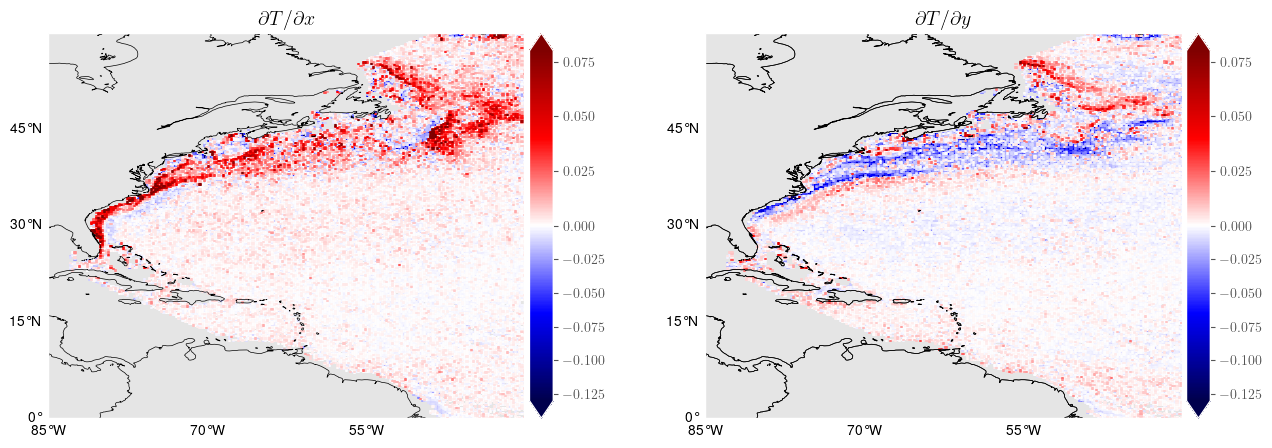

In [39]:


metric_names = ['sst_x_derivative', 'sst_y_derivative']#, 'coverage Indep', 'coverage', 'area', 'NLL_det', 'count']
cbar_names = ["", "", "", "", "", "", "", ""]
titles = [r'$\displaystyle \partial T/\partial x $',
          r'$\displaystyle \partial T/\partial y $',
         ]


fig, axs = plt.subplots(1,2,figsize=(15,5), subplot_kw= {"projection":ccrs.PlateCarree()})
print('fig successful')
for i, metric in enumerate(metric_names):
    col = int(i%2)
    row = int((i-col)/2)
    current_ax = axs[col]
    cax = plot_column(plot_frame_sst,
                      metric,
                      ax=current_ax,
                      cmap='seismic',
                      vmin_manual=-0.13,
                      vmax_manual=0.08)
    print(f'{metric} plot successful')
    current_ax.set_title(titles[i])
    current_ax.set_extent(extent,ccrs.PlateCarree())
    current_ax.coastlines()
    current_ax.set_aspect('auto')
    add_gridlines(current_ax)
    cax.set_ylabel(cbar_names[i], labelpad=0.1)
    
add_letters(axs)
print('letters added')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
#axs[1,1].quiver(spatial_summaries['lon'], spatial_summaries['lat'], spatial_summaries['mean_lon'], spatial_summaries['mean_lat'], zorder=15)
axs[1].coastlines()
axs[1].set_aspect('auto')
#axs[1,1].set_title("Mean Predicted Velocity")
#fig.tight_layout()

plt.show()

## Investigating Data Distributions

Things I need to comment on here (theory):
* Expected behaviour of sea surface temperature gradients, particularly in different distinct regions.
* Expected temperature gradient ranges in the North West Atlantic
* The extreme valueness of it all
* Seasonal patterns

# Whole Domain (North Atlantic between 83W and 40W)


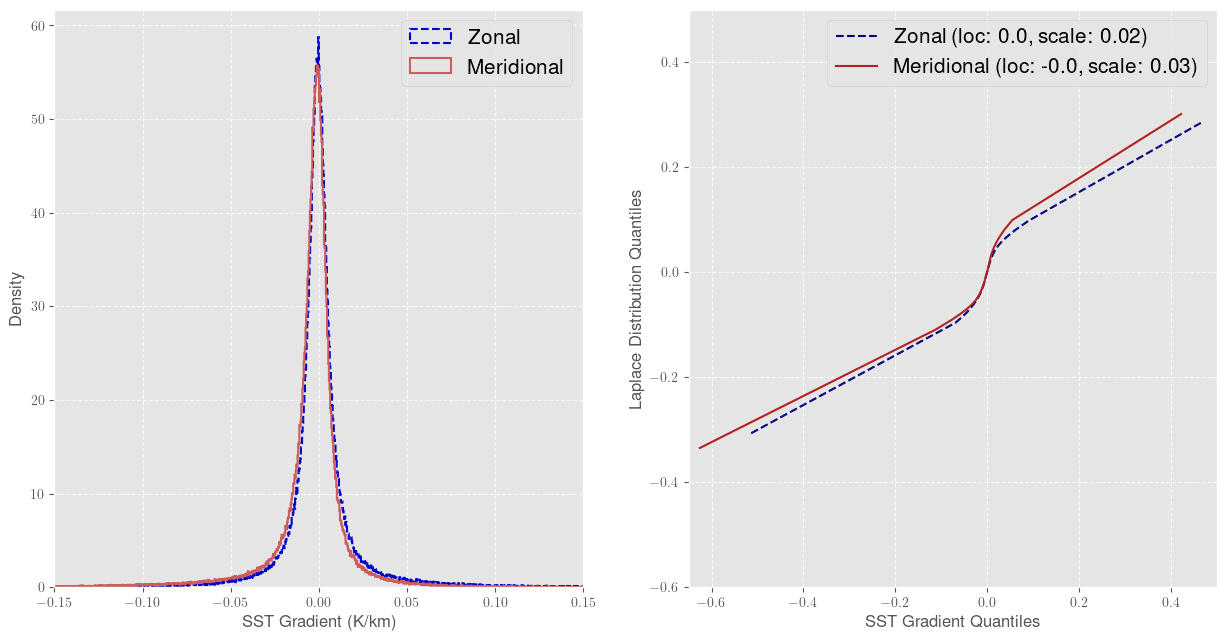

In [17]:
# get sst gradient values
region_sst_grad_x = drifter_dataset['sst_x_derivative'].values
region_sst_grad_y = drifter_dataset['sst_y_derivative'].values

summary_plots(region_sst_grad_x,region_sst_grad_y,bins=3000)


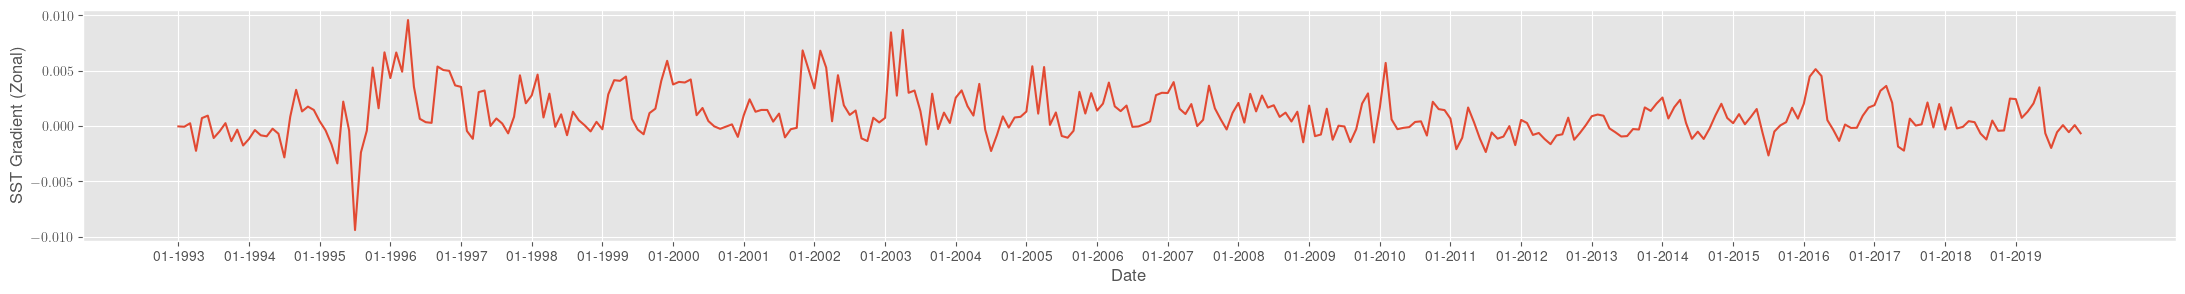

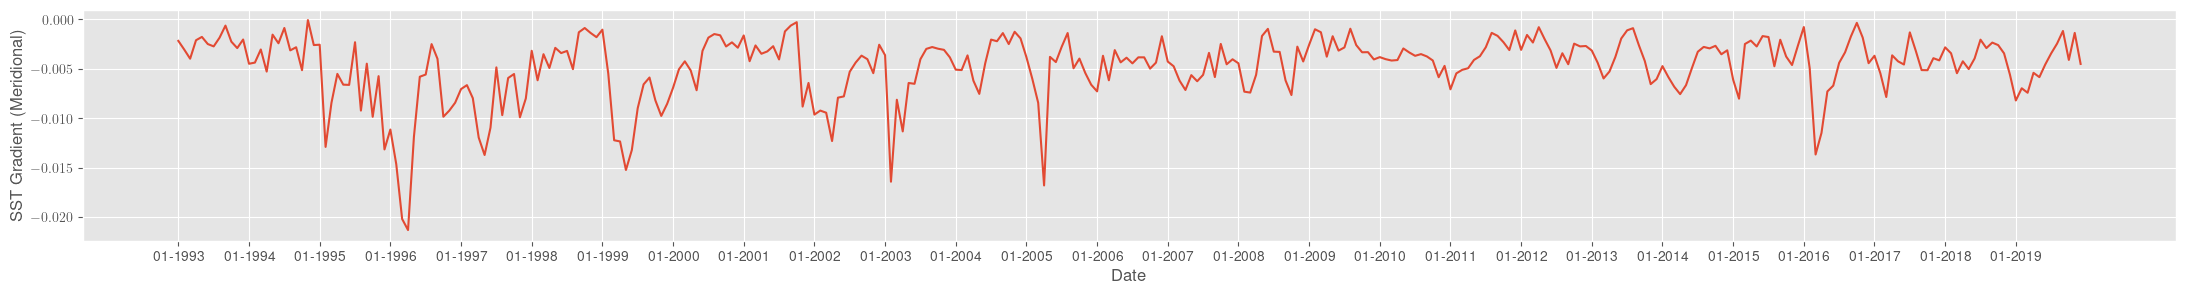

In [18]:
# SST gradient time series

sst_gradient_time_series = drifter_dataset.groupby([(drifter_dataset.time.dt.year), (drifter_dataset.time.dt.month)])[['sst_x_derivative','sst_y_derivative']].mean()

new_index = sst_gradient_time_series.index.rename(['year','month'])
#sst_gradient_time_series[['year','month']] = new_index

sst_gradient_time_series = sst_gradient_time_series.reindex(new_index)
sst_gradient_time_series = sst_gradient_time_series.rename_axis(['year','month']).reset_index()


sst_gradient_time_series['date'] = sst_gradient_time_series['month'].map(str)+ '-' +sst_gradient_time_series['year'].map(str)
sst_gradient_time_series['date'] = pd.to_datetime(sst_gradient_time_series['date'], format='%m-%Y').dt.strftime('%m-%Y')
fig, ax = plt.subplots(figsize=(27,3))
ax.set_xlabel('Date')
ax.set_ylabel('SST Gradient (Zonal)')
ax.plot(sst_gradient_time_series['date'], sst_gradient_time_series['sst_x_derivative'])
plt.xticks(np.arange(0,12*(2020-1993),12))
plt.show()

fig_y, ax_y = plt.subplots(figsize=(27,3))
ax_y.set_xlabel('Date')
ax_y.set_ylabel('SST Gradient (Meridional)')
ax_y.plot(sst_gradient_time_series['date'], sst_gradient_time_series['sst_y_derivative'])
plt.xticks(np.arange(0,12*(2020-1993),12))
plt.show()



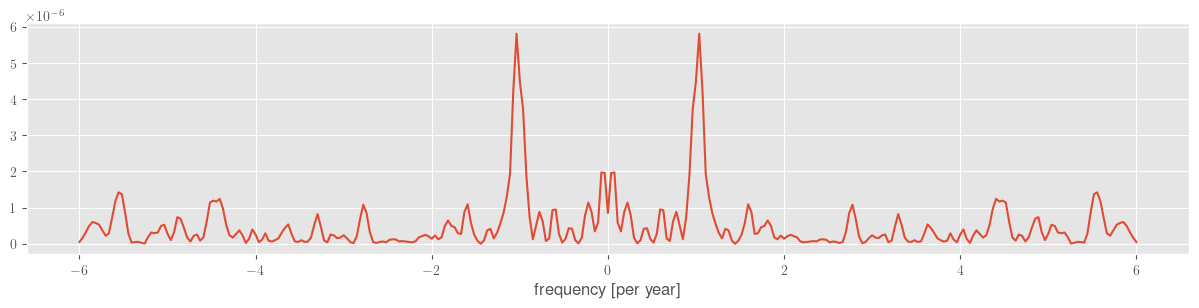

In [19]:
# Periodogram
from scipy.signal import periodogram
from scipy.signal import windows

fig_ft,ax_ft = plt.subplots(figsize=(15,3))
frequencies,periodogram_values = periodogram(sst_gradient_time_series['sst_x_derivative'],fs=12,return_onesided=True,window=windows.flattop(sst_gradient_time_series.shape[0])) #'12 times per year'
negative_vals = [val for val in reversed(periodogram_values)]
negative_freqs = [-val for val in reversed(frequencies)]
# Plotting the spectrum
ax_ft.plot(np.concatenate([negative_freqs,frequencies]), np.concatenate([negative_vals,periodogram_values]))
ax_ft.set_xlabel('frequency [per year]')
plt.show()

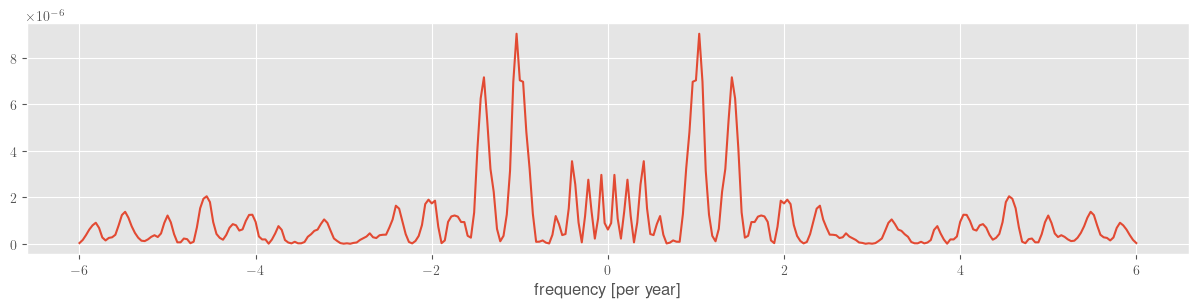

In [20]:
# Periodogram
from scipy.signal import periodogram
from scipy.signal import windows

fig_ft,ax_ft = plt.subplots(figsize=(15,3))
frequencies,periodogram_values = periodogram(sst_gradient_time_series['sst_y_derivative'],fs=12,return_onesided=True,window=windows.flattop(sst_gradient_time_series.shape[0])) #'12 times per year'
negative_vals = [val for val in reversed(periodogram_values)]
negative_freqs = [-val for val in reversed(frequencies)]
# Plotting the spectrum
ax_ft.plot(np.concatenate([negative_freqs,frequencies]), np.concatenate([negative_vals,periodogram_values]))
ax_ft.set_xlabel('frequency [per year]')
plt.show()

## The Gulf Stream Region

Here this region is defined between 75W and 55W longitude and 35N to 40N latitude.

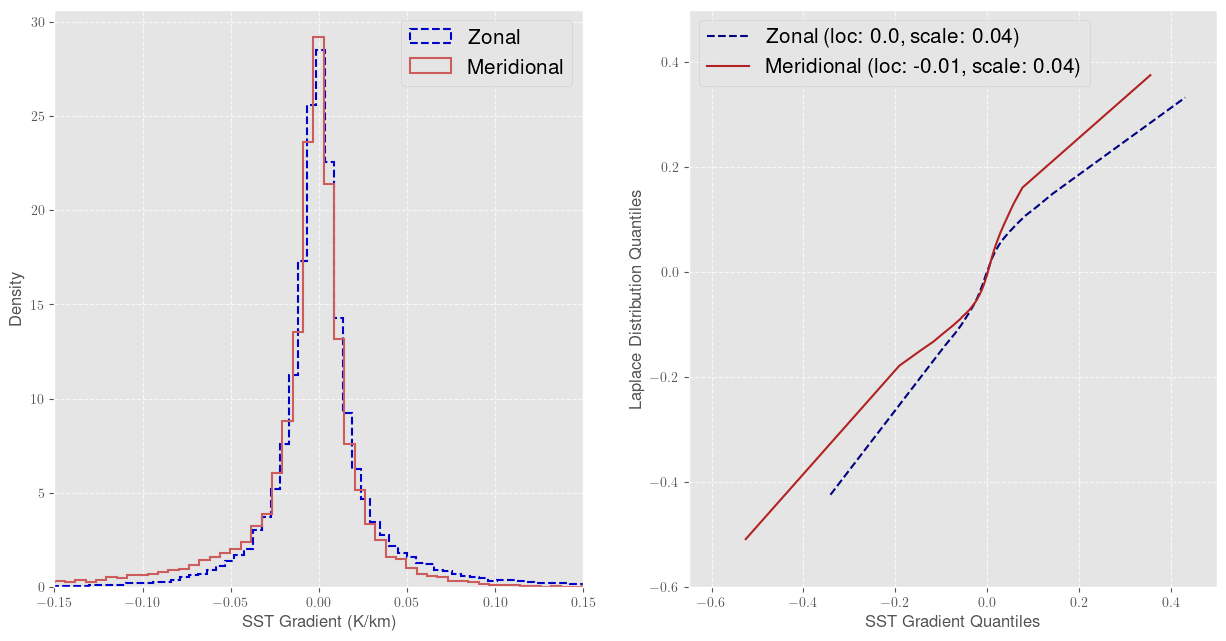

In [21]:
# get sst gradient values
region_sst_grad_x = drifter_dataset
region_sst_grad_y = drifter_dataset.query('-75 < lon < -55 and 35 <lat <40')['sst_y_derivative'].values

summary_plots(region_sst_grad_x,region_sst_grad_y,bins=150)


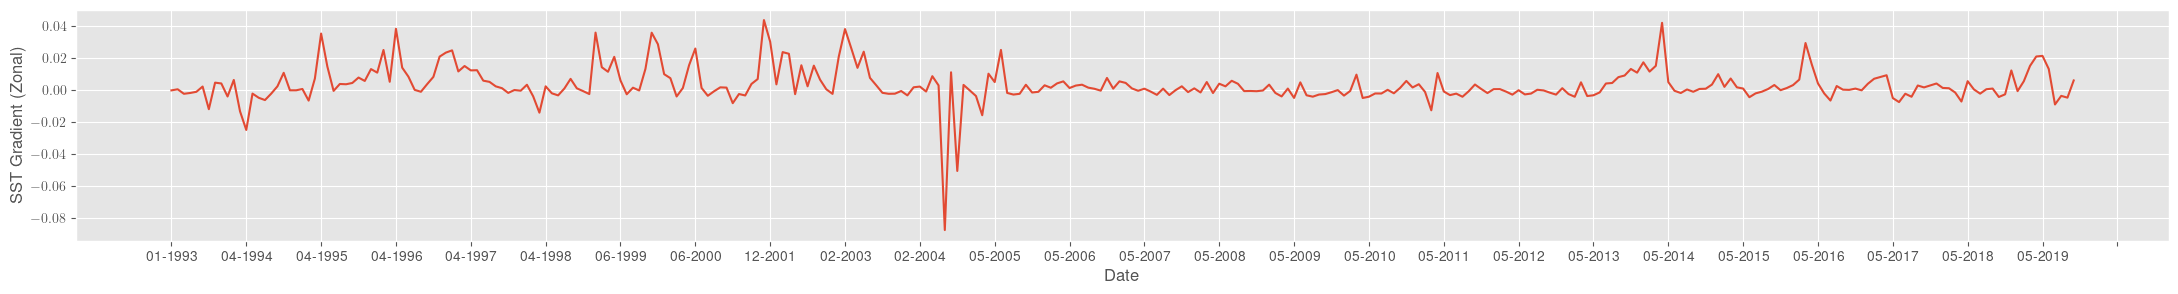

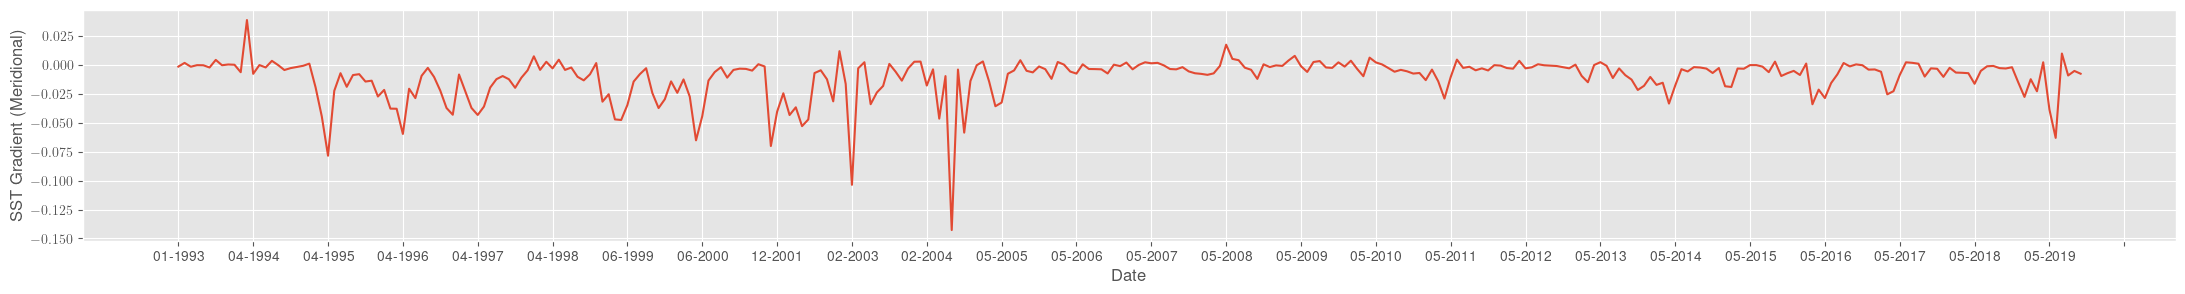

In [22]:
# SST gradient time series

sst_gradient_time_series = drifter_dataset.query('-75 < lon < -55 and 35 <lat <40').groupby([(drifter_dataset.time.dt.year), (drifter_dataset.time.dt.month)])[['sst_x_derivative','sst_y_derivative']].mean()

new_index = sst_gradient_time_series.index.rename(['year','month'])
#sst_gradient_time_series[['year','month']] = new_index

sst_gradient_time_series = sst_gradient_time_series.reindex(new_index)
sst_gradient_time_series = sst_gradient_time_series.rename_axis(['year','month']).reset_index()


sst_gradient_time_series['date'] = sst_gradient_time_series['month'].map(str)+ '-' +sst_gradient_time_series['year'].map(str)
sst_gradient_time_series['date'] = pd.to_datetime(sst_gradient_time_series['date'], format='%m-%Y').dt.strftime('%m-%Y')
fig, ax = plt.subplots(figsize=(27,3))
ax.set_xlabel('Date')
ax.set_ylabel('SST Gradient (Zonal)')
ax.plot(sst_gradient_time_series['date'], sst_gradient_time_series['sst_x_derivative'])
plt.xticks(np.arange(0,12*(2020-1993),12))
plt.show()

fig_y, ax_y = plt.subplots(figsize=(27,3))
ax_y.set_xlabel('Date')
ax_y.set_ylabel('SST Gradient (Meridional)')
ax_y.plot(sst_gradient_time_series['date'], sst_gradient_time_series['sst_y_derivative'])
plt.xticks(np.arange(0,12*(2020-1993),12))
plt.show()



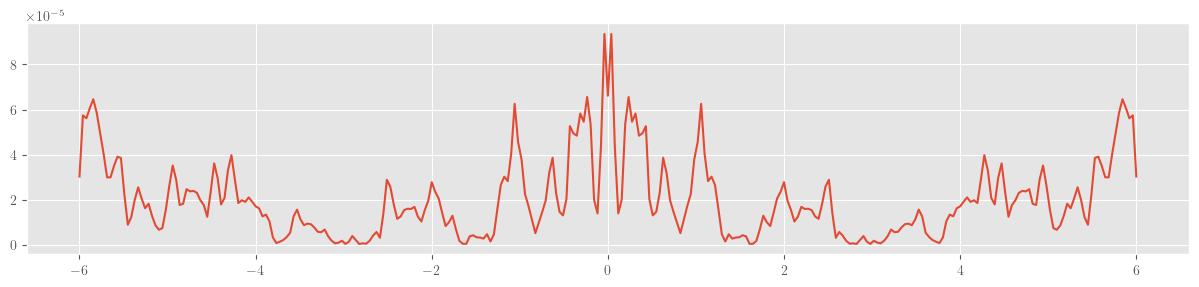

In [23]:
fig_ft,ax_ft = plt.subplots(figsize=(15,3))
frequencies,periodogram_values = periodogram(sst_gradient_time_series['sst_x_derivative'],fs=12,return_onesided=True,window=windows.flattop(sst_gradient_time_series.shape[0])) #'12 times per year'
negative_vals = [val for val in reversed(periodogram_values)]
negative_freqs = [-val for val in reversed(frequencies)]

# Plotting the spectrum
ax_ft.plot(np.concatenate([negative_freqs,frequencies]), np.concatenate([negative_vals,periodogram_values]))
#ax_ft.axvline(0.5)
plt.show()

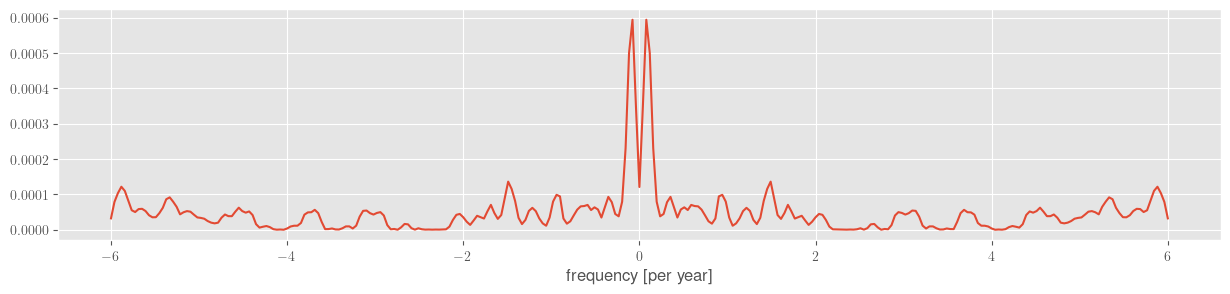

In [24]:
fig_ft,ax_ft = plt.subplots(figsize=(15,3))
frequencies,periodogram_values = periodogram(sst_gradient_time_series['sst_y_derivative'],fs=12,return_onesided=True,window=windows.flattop(sst_gradient_time_series.shape[0])) #'12 times per year'
negative_vals = [val for val in reversed(periodogram_values)]
negative_freqs = [-val for val in reversed(frequencies)]
# Plotting the spectrum
ax_ft.plot(np.concatenate([negative_freqs,frequencies]), np.concatenate([negative_vals,periodogram_values]))
ax_ft.set_xlabel('frequency [per year]')
plt.show()

## Labrador Sea Region

Here this region is defined as (lat, lon) that are above the line (51.4N, 52.02W) and (52.02N,55.15W) and in the North Atlantic Ocean.

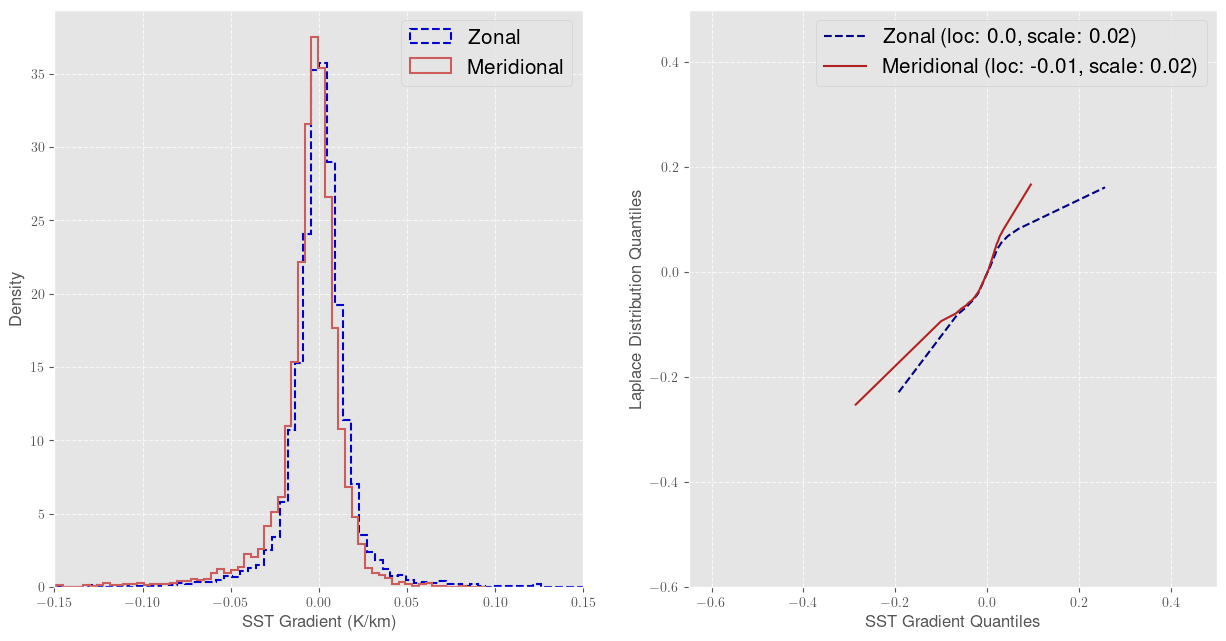

In [25]:
# get sst gradient values
c,m = np.polyfit([51.4,-52.02],[52.02,-55.15],1)
region_sst_grad_x  = drifter_dataset.query('lat > @m*lon + @c')['sst_x_derivative'].values
region_sst_grad_y  = drifter_dataset.query('lat> @m*lon + @c')['sst_y_derivative'].values

summary_plots(region_sst_grad_x,region_sst_grad_y,bins=100)

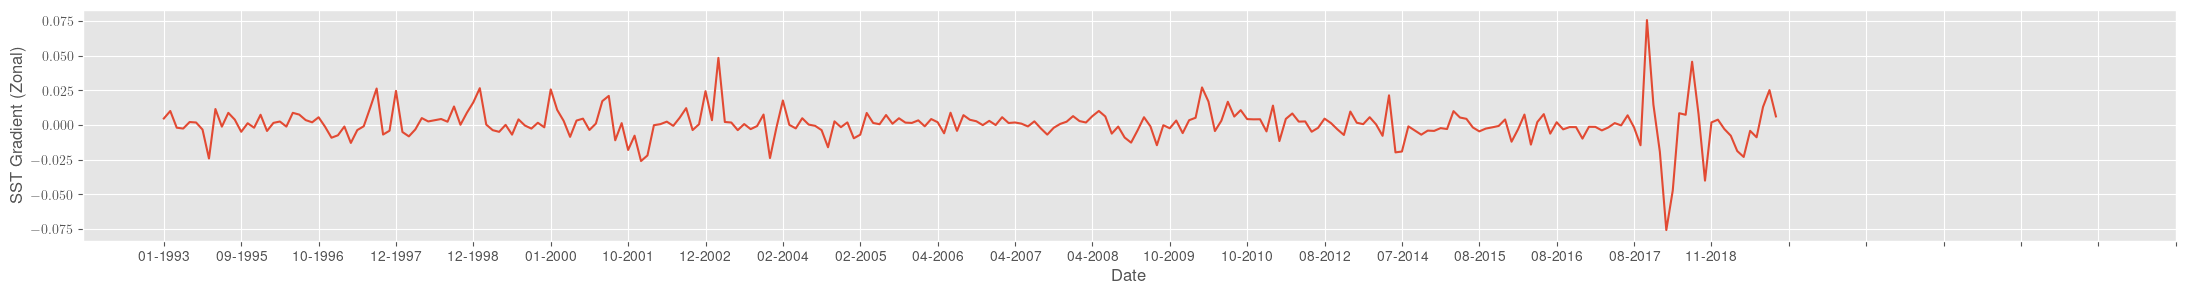

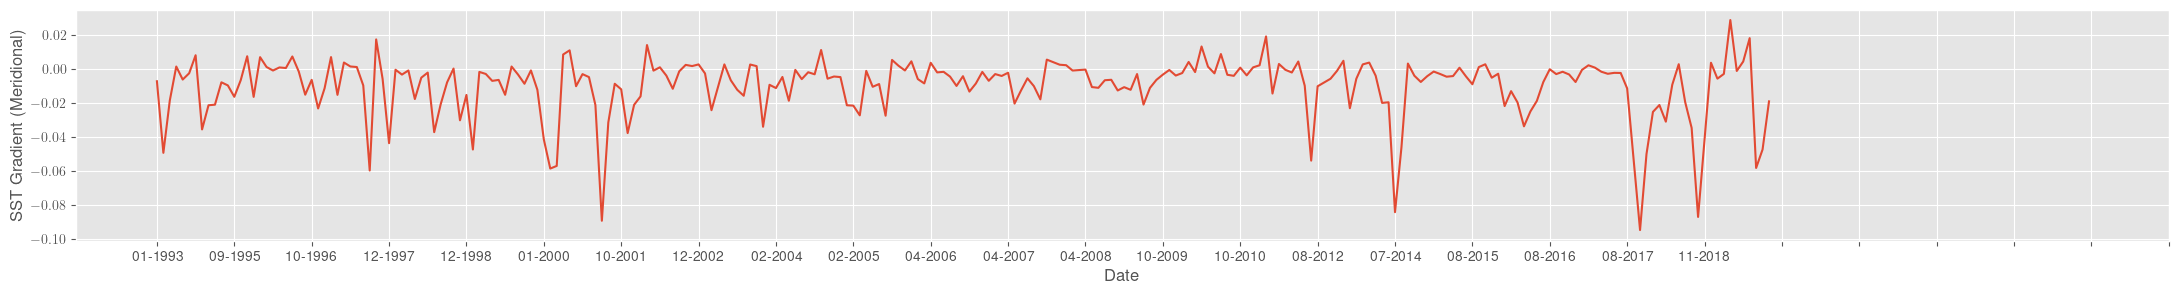

In [26]:
# SST gradient time series

sst_gradient_time_series = drifter_dataset.query('lat > @m*lon + @c').groupby([(drifter_dataset.time.dt.year), (drifter_dataset.time.dt.month)])[['sst_x_derivative','sst_y_derivative']].mean()

new_index = sst_gradient_time_series.index.rename(['year','month'])
#sst_gradient_time_series[['year','month']] = new_index

sst_gradient_time_series = sst_gradient_time_series.reindex(new_index)
sst_gradient_time_series = sst_gradient_time_series.rename_axis(['year','month']).reset_index()


sst_gradient_time_series['date'] = sst_gradient_time_series['month'].map(str)+ '-' +sst_gradient_time_series['year'].map(str)
sst_gradient_time_series['date'] = pd.to_datetime(sst_gradient_time_series['date'], format='%m-%Y').dt.strftime('%m-%Y')
fig, ax = plt.subplots(figsize=(27,3))
ax.set_xlabel('Date')
ax.set_ylabel('SST Gradient (Zonal)')
ax.plot(sst_gradient_time_series['date'], sst_gradient_time_series['sst_x_derivative'])
plt.xticks(np.arange(0,12*(2020-1993),12))
plt.show()

fig_y, ax_y = plt.subplots(figsize=(27,3))
ax_y.set_xlabel('Date')
ax_y.set_ylabel('SST Gradient (Meridional)')
ax_y.plot(sst_gradient_time_series['date'], sst_gradient_time_series['sst_y_derivative'])
plt.xticks(np.arange(0,12*(2020-1993),12))
plt.show()



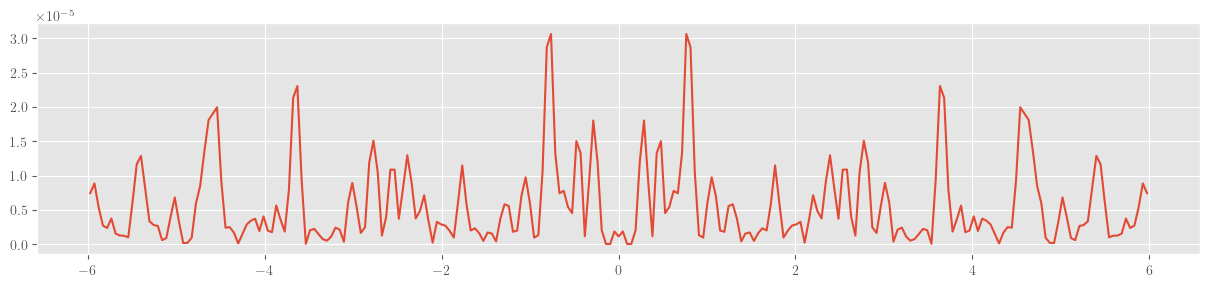

In [27]:
fig_ft,ax_ft = plt.subplots(figsize=(15,3))
frequencies,periodogram_values = periodogram(sst_gradient_time_series['sst_x_derivative'],fs=12,return_onesided=True,window=windows.flattop(sst_gradient_time_series.shape[0])) #'12 times per year'
negative_vals = [val for val in reversed(periodogram_values)]
negative_freqs = [-val for val in reversed(frequencies)]

# Plotting the spectrum
ax_ft.plot(np.concatenate([negative_freqs,frequencies]), np.concatenate([negative_vals,periodogram_values]))
#ax_ft.axvline(14/365)
plt.show()

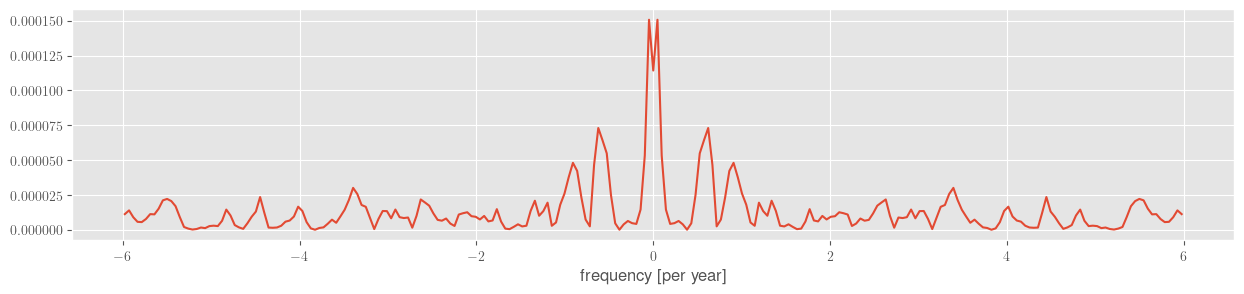

In [28]:

fig_ft,ax_ft = plt.subplots(figsize=(15,3))
frequencies,periodogram_values = periodogram(sst_gradient_time_series['sst_y_derivative'],fs=12,return_onesided=True,window=windows.flattop(sst_gradient_time_series.shape[0])) #'12 times per year'
negative_vals = [val for val in reversed(periodogram_values)]
negative_freqs = [-val for val in reversed(frequencies)]
# Plotting the spectrum
ax_ft.plot(np.concatenate([negative_freqs,frequencies]), np.concatenate([negative_vals,periodogram_values]))
ax_ft.set_xlabel('frequency [per year]')
plt.show()

## Equatorial Region

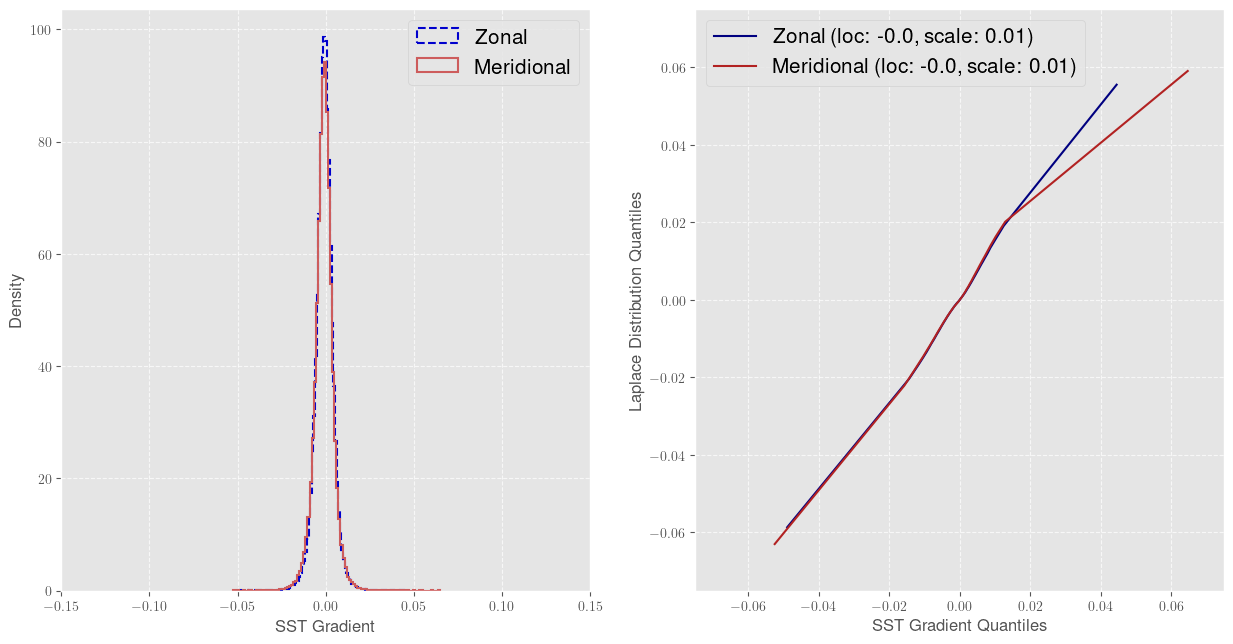

In [29]:
from seaducks.config import config
from seaducks.analysis import q_q_laplace,q_q_normal
num_quantiles = 100
seed = config['random_state']
bins = 100

# get sst gradient values
region_sst_grad_x  = drifter_dataset.query('lat <23.26')['sst_x_derivative'].values
region_sst_grad_y  = drifter_dataset.query('lat<23.26')['sst_y_derivative'].values

# plot histogram and Q-Q plot
## configuration
fig_region, ax_region = plt.subplots(ncols=2, figsize = (15,7.55))
ax_hist, ax_qq = ax_region
## --------------- Zonal --------------- ##
### histogram
ax_hist.grid(True,linestyle='--',alpha=0.7)
ax_hist.set_xlabel("SST Gradient")
ax_hist.set_ylabel("Density")
ax_hist.set_xlim(-0.15,0.15)
### q-q plot
ax_qq.grid(True,linestyle='--',alpha=0.7)
ax_qq.set_xlabel("SST Gradient Quantiles")
ax_qq.set_ylabel("Laplace Distribution Quantiles")
ax_qq.set_xlim(-0.6,0.5)
ax_qq.set_ylim(-0.6,0.5)
### plotting
ax_hist.hist(region_sst_grad_x,bins = bins,density=True,color='mediumblue',histtype=u'step',ls='--', lw=1.5)
qq = q_q_laplace(region_sst_grad_x,num_quantiles=num_quantiles,seed=seed)
ax_qq.plot(qq[0],qq[1],color='navy')
## -------------- Meridional -------------- ##
### histogram
ax_hist.grid(True,linestyle='--',alpha=0.7)
ax_hist.set_xlim(-0.15,0.15)
### q-q plot
ax_qq.grid(True,linestyle='--',alpha=0.7)
ax_qq.set_xlim(-0.075,0.075)
ax_qq.set_ylim(-0.075,0.075)
### plotting
ax_hist.hist(region_sst_grad_y,bins = bins,density=True,histtype=u'step',color='indianred', lw=1.5)
qq = q_q_laplace(region_sst_grad_y,num_quantiles=num_quantiles,seed=seed)
ax_qq.plot(qq[0],qq[1],color='firebrick')


ax_hist.legend(['Zonal', 'Meridional'],prop={'size': 15})
ax_qq.legend([f'Zonal (loc: {round(np.mean(region_sst_grad_x),2)}, scale: {round(np.std(region_sst_grad_x),2)})', 
            f'Meridional (loc: {round(np.mean(region_sst_grad_y),2)}, scale: {round(np.std(region_sst_grad_y),2)})'],
            prop={'size': 15})
plt.show()

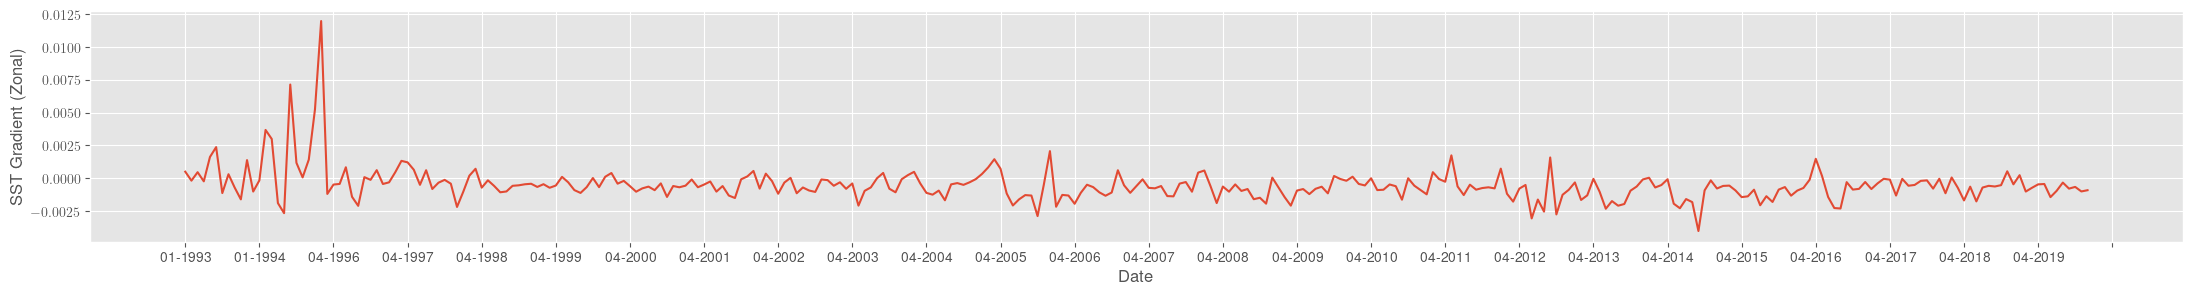

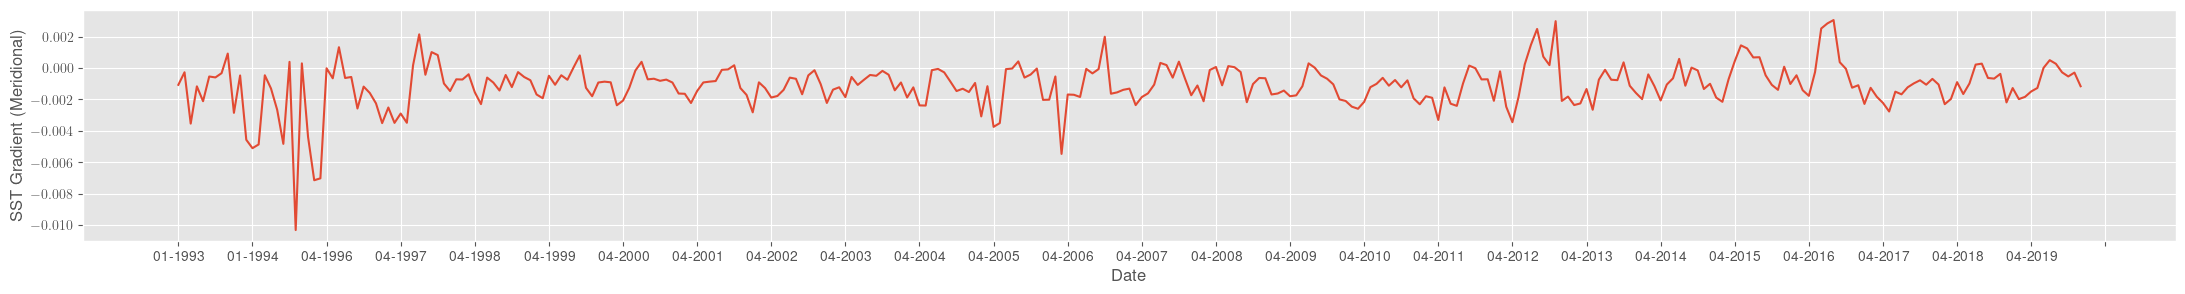

In [30]:
# SST gradient time series

sst_gradient_time_series = drifter_dataset.query('lat <23.26').groupby([(drifter_dataset.time.dt.year), (drifter_dataset.time.dt.month)])[['sst_x_derivative','sst_y_derivative']].mean()

new_index = sst_gradient_time_series.index.rename(['year','month'])
#sst_gradient_time_series[['year','month']] = new_index

sst_gradient_time_series = sst_gradient_time_series.reindex(new_index)
sst_gradient_time_series = sst_gradient_time_series.rename_axis(['year','month']).reset_index()


sst_gradient_time_series['date'] = sst_gradient_time_series['month'].map(str)+ '-' +sst_gradient_time_series['year'].map(str)
sst_gradient_time_series['date'] = pd.to_datetime(sst_gradient_time_series['date'], format='%m-%Y').dt.strftime('%m-%Y')
fig, ax = plt.subplots(figsize=(27,3))
ax.set_xlabel('Date')
ax.set_ylabel('SST Gradient (Zonal)')
ax.plot(sst_gradient_time_series['date'], sst_gradient_time_series['sst_x_derivative'])
plt.xticks(np.arange(0,12*(2020-1993),12))
plt.show()

fig_y, ax_y = plt.subplots(figsize=(27,3))
ax_y.set_xlabel('Date')
ax_y.set_ylabel('SST Gradient (Meridional)')
ax_y.plot(sst_gradient_time_series['date'], sst_gradient_time_series['sst_y_derivative'])
plt.xticks(np.arange(0,12*(2019.5-1993),12))
plt.show()



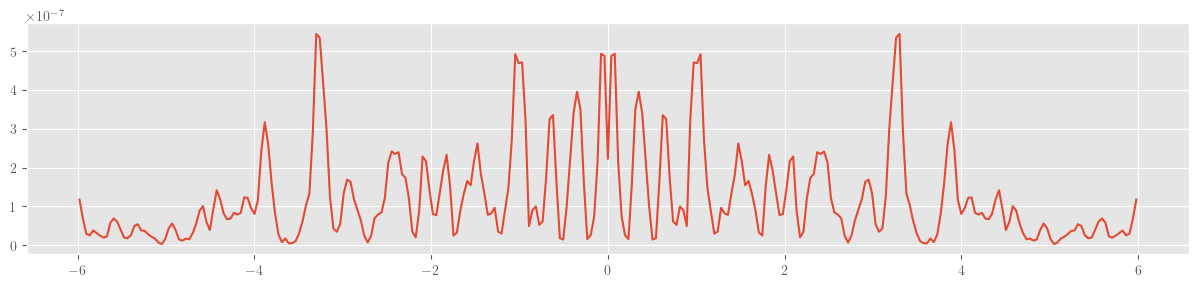

In [31]:
fig_ft,ax_ft = plt.subplots(figsize=(15,3))
frequencies,periodogram_values = periodogram(sst_gradient_time_series['sst_x_derivative'],fs=12,return_onesided=True,window=windows.flattop(sst_gradient_time_series.shape[0])) #'12 times per year'
negative_vals = [val for val in reversed(periodogram_values)]
negative_freqs = [-val for val in reversed(frequencies)]

# Plotting the spectrum
ax_ft.plot(np.concatenate([negative_freqs,frequencies]), np.concatenate([negative_vals,periodogram_values]))
plt.show()

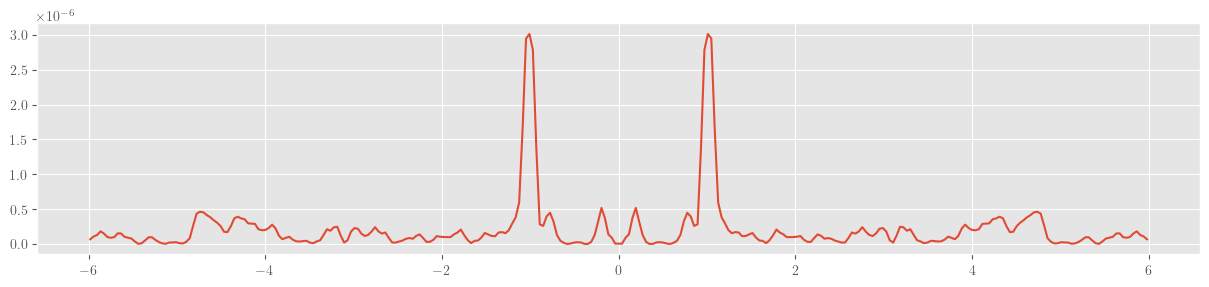

In [32]:
fig_ft,ax_ft = plt.subplots(figsize=(15,3))
frequencies,periodogram_values = periodogram(sst_gradient_time_series['sst_y_derivative'],fs=12,return_onesided=True,window=windows.flattop(sst_gradient_time_series.shape[0])) #'12 times per year'
negative_vals = [val for val in reversed(periodogram_values)]
negative_freqs = [-val for val in reversed(frequencies)]

# Plotting the spectrum
ax_ft.plot(np.concatenate([negative_freqs,frequencies]), np.concatenate([negative_vals,periodogram_values]))
plt.show()